# Klarna Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from collections import Counter


## Data Retrieval

In [2]:
def get_col_info():
    colInfo = 'CaseStudyCols.csv'

    with open(colInfo, newline='') as csv_file:
        reader = csv.reader(csv_file, delimiter=';')
        # skip over the first row
        reader.__next__()
        rows = list(reader)

    col_names_types = {row[0]: row[1] for row in rows}

    return col_names_types

In [3]:
"""
Note that in reality the column 'default' and
'worst_status_active_inv' as actually ints, but
since they have NA values, we load them as objects
for now.

But note that the entries where default = NA are actually our
entries that we are supposed to predict (validate set?)
"""

df = pd.read_csv('dataset.csv', delimiter=';', dtype = get_col_info(), keep_default_na=True)

## Data Processing & Wrangling

In [4]:
# Strip out the NA entries for the column 'default'
# First we save the entries to a seperate dataframe

defaults_df = df[df['default'].isna().copy()]

df = df[df['default'].notna().copy()]
df['default'] = pd.to_numeric(df['default']).astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 89976 non-null  object 
 1   default                              89976 non-null  int32  
 2   account_amount_added_12_24m          89976 non-null  int32  
 3   account_days_in_dc_12_24m            79293 non-null  float64
 4   account_days_in_rem_12_24m           79293 non-null  float64
 5   account_days_in_term_12_24m          79293 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  36619 non-null  float64
 7   account_status                       41042 non-null  float64
 8   account_worst_status_0_3m            41042 non-null  float64
 9   account_worst_status_12_24m          29921 non-null  float64
 10  account_worst_status_3_6m            38038 non-null  float64
 11  account_worst_status_6_12m  

## Basic EDA

### Columns with higher percentage of NA

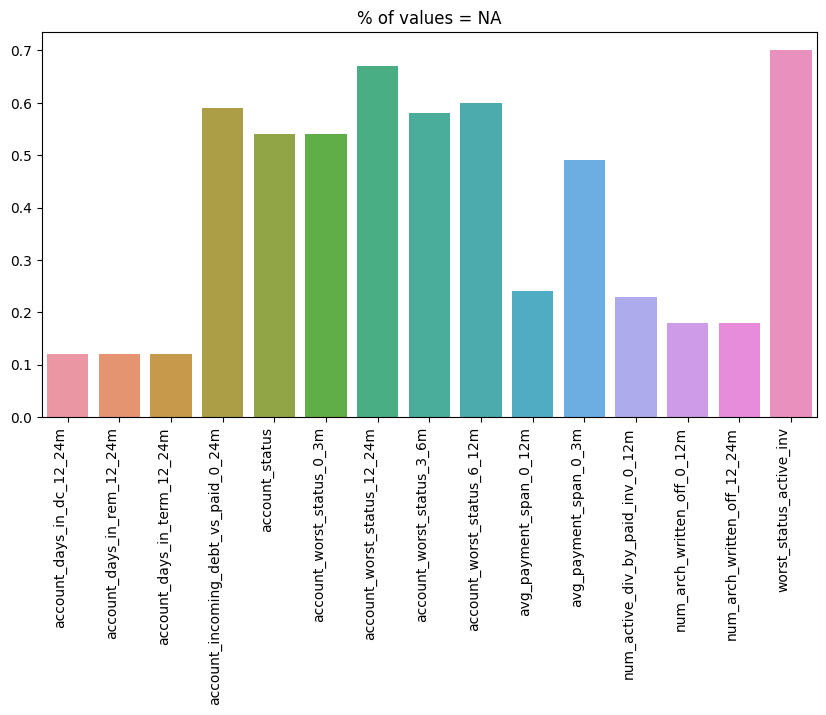

In [5]:
# Explore the dataset, in particular look at the NA counts
has_na = []
for col in df.columns:
    perc_na = 0
    perc_na = round(df[col].isna().sum()/len(df), 2)
    if perc_na > 0:
        has_na.append([col, perc_na])


# Plot out the columns with NA (their percentages) - no need to show it each time
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
na_plot = sns.barplot(x=[n[0] for n in has_na], y=[n[1] for n in has_na],  ax=ax)
na_plot.set_xticklabels(na_plot.get_xticklabels(), rotation=90, horizontalalignment='right')
na_plot.set_title("% of values = NA");


In [6]:
## Let's explore some of the columns (other than default)
## Look in particular at the columns with high NA.
## Do we need those columns or can we simply drop them?

In [7]:
## Make a list of columns that have high % NA
# % NA threshhold for columns to ignore
na_threshold = .3
cols_to_exclude = [col[0] for col in has_na if col[1] > na_threshold]

In [8]:
## We can see that 'merchant_category', 'merchant_group'
## and 'name_in_email' are categorical (object = string)
## These will either need to be ignored (not a good idea)
## or encoded.

In [9]:
# Have a look at the two 'merchant_' columns
for c in df.columns:
    if(c[:8] == 'merchant'):
            print(df[c].value_counts())
df.info()

Diversified entertainment                                  34781
Youthful Shoes & Clothing                                  10524
Books & Magazines                                           8447
General Shoes & Clothing                                    4162
Concept stores & Miscellaneous                              3969
Sports gear & Outdoor                                       3356
Dietary supplements                                         2777
Diversified children products                               2691
Diversified electronics                                     1627
Prints & Photos                                             1502
Children Clothes & Nurturing products                       1357
Pet supplies                                                1185
Electronic equipment & Related accessories                   946
Hobby articles                                               817
Jewelry & Watches                                            815
Prescription optics      

### Check the targets too

<AxesSubplot:title={'center':'Targets'}, ylabel='default'>

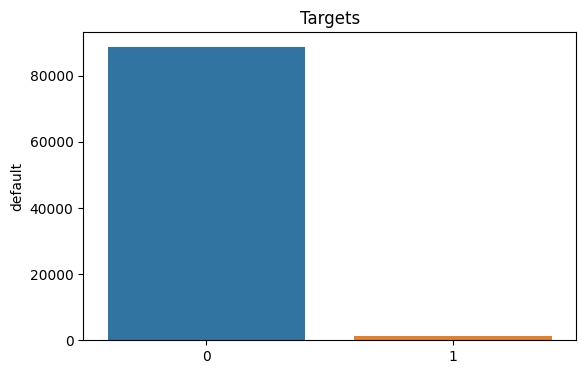

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Targets")
sns.barplot(x=df['default'].unique(), y = df['default'].value_counts())

<font color="orange">***Note that the targets are highly unequel, this will need to be managed***</font>

## Basic Feature Selection

### Look for correlations

,feature_1,feature_2,correlation,absolute_correlation
621,max_paid_inv_0_24m,max_paid_inv_0_12m,0.889912,0.889912
584,max_paid_inv_0_12m,max_paid_inv_0_24m,0.889912,0.889912
818,num_arch_ok_0_12m,num_arch_ok_12_24m,0.864148,0.864148
855,num_arch_ok_12_24m,num_arch_ok_0_12m,0.864148,0.864148
1245,status_max_archived_0_24_months,status_max_archived_0_12_months,0.842982,0.842982
1208,status_max_archived_0_12_months,status_max_archived_0_24_months,0.842982,0.842982
1241,status_max_archived_0_24_months,status_last_archived_0_24m,0.765443,0.765443
1056,status_last_archived_0_24m,status_max_archived_0_24_months,0.765443,0.765443
468,avg_payment_span_0_12m,avg_payment_span_0_3m,0.742573,0.742573
505,avg_payment_span_0_3m,avg_payment_span_0_12m,0.742573,0.742573


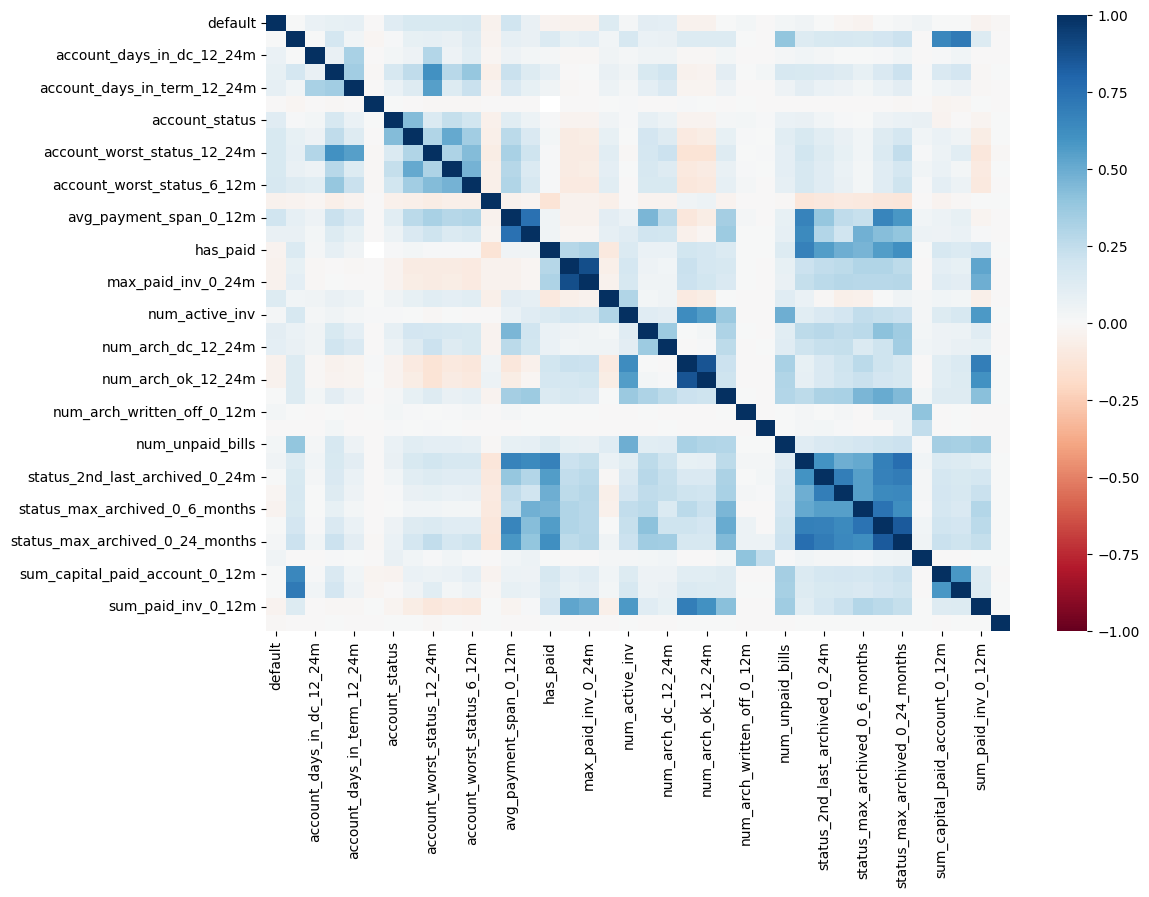

In [11]:
def corr_matrix(df):
    correlation_matrix = df.corr()
    column_names = correlation_matrix.columns

    # Convert the correlation matrix into a DataFrame
    corr_df = correlation_matrix.stack().reset_index()

    # Rename the columns
    corr_df.columns = ['feature_1','feature_2', 'correlation']

    # Remove "self correlations"
    no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
    corr_df = corr_df[no_self_correlation]

    # Absolute correlation
    corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

    #Plot it
    ax = sns.heatmap(correlation_matrix, vmin=-1, cmap='RdBu')
    ax.get_figure().set_size_inches(w=12, h=8)

    # Correlation by pairs of features
    return corr_df.sort_values(by="absolute_correlation", ascending=False)

corr_matrix(df).head(10)

In [12]:
## There are already 36 columns in the original dataset. A bit less after we
## removed the high percentage NA columns. Before getting into the pipeline
## let's remove some columns that are probably not needed.

## We'll use the list of columns with high NA percentages created during the
## EDA to append additional columns to be excluded.

## First, columns that are highly correlated (corr > .8)
cols_to_exclude +=  ['max_paid_inv_0_24m', 'num_arch_ok_0_12m', \
                    'status_max_archived_0_24_months']

## Next, categorical columns that 'probably' don't add much value
## We still have the 'merchant_group' column that should be usefule
cols_to_exclude += ['merchant_category', 'name_in_email']

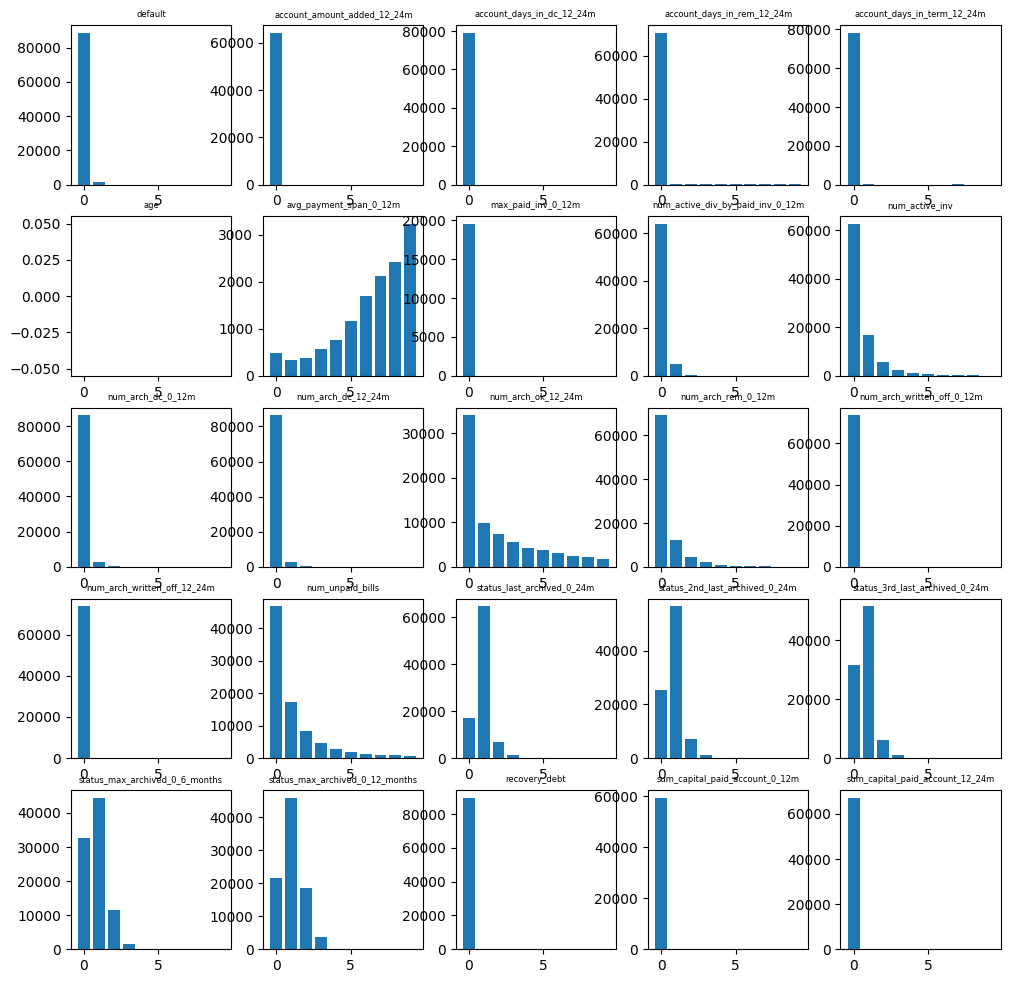

In [13]:
# Now that we've done some feaure selection, let's look again at the
# data in the columns that remain

cols_to_plot = df.drop(columns=cols_to_exclude).copy()

# Let's plot the distributions of the numeric columns, those not excluded
num_cols = cols_to_plot.select_dtypes(include='number').describe().columns.to_list()

c = 5
r = int(round(len(num_cols)/c,0))

fig, axes = plt.subplots(ncols=c, nrows=r, figsize=[12,12])
for col, ax in zip(num_cols, axes.ravel()):
    counts, bins = np.histogram(df[col], bins=np.arange(-0.5,10.5))
    ax.bar(bins[1:]-0.5, counts)
    ax.set_title(col, fontsize=6)


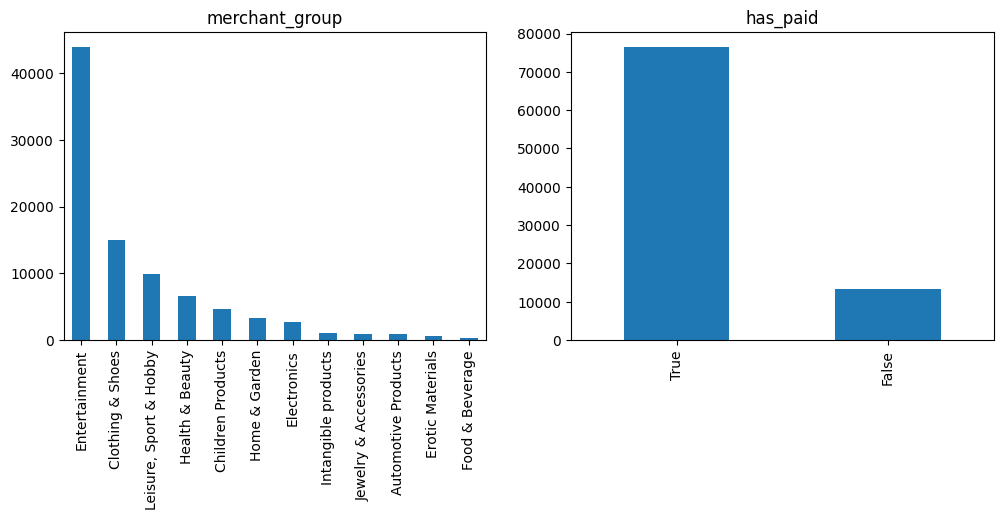

In [14]:
cols_to_plot = cols_to_plot.drop(columns=['uuid']).copy()
# # Let's plot the distributions of the categorical columns, those not excluded
cat_cols = cols_to_plot.select_dtypes(exclude='number').describe().columns.to_list()
fig, ax = plt.subplots(ncols=len(cat_cols), nrows=1, figsize=[12,4])
for i, col in enumerate(df[cat_cols]):
    df[col].value_counts().plot.bar(ax=ax[i]).set_title(col)


## Model - Pipeline

In [15]:
cols_to_exclude += ['default', 'uuid']

# Defining the features and the target
def get_x_y():
    X = df.drop(columns=cols_to_exclude)
    y = df['default']
    return X, y

def get_splits():

    X, y = get_x_y()

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = get_splits()

(71980, 28) (17996, 28) (71980,) (17996,)


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71980 entries, 27330 to 16866
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   account_amount_added_12_24m       71980 non-null  int32  
 1   account_days_in_dc_12_24m         63440 non-null  float64
 2   account_days_in_rem_12_24m        63440 non-null  float64
 3   account_days_in_term_12_24m       63440 non-null  float64
 4   age                               71980 non-null  int32  
 5   avg_payment_span_0_12m            54894 non-null  float64
 6   merchant_group                    71980 non-null  object 
 7   has_paid                          71980 non-null  bool   
 8   max_paid_inv_0_12m                71980 non-null  float64
 9   num_active_div_by_paid_inv_0_12m  55542 non-null  float64
 10  num_active_inv                    71980 non-null  int32  
 11  num_arch_dc_0_12m                 71980 non-null  int32  
 12  

### Define some methods for the model, etc.

In [18]:
def init_pipe():

    X, y = get_x_y()


    # Impute then scale numerical values:
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])

    # Encode categorical values
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    # Parallelize "num_transformer" and "cat_transfomer"
    numeric_cols = X.select_dtypes(include='number').describe().columns.to_list()
    cat_cols = X.select_dtypes(include=['object', 'bool']).describe().columns.to_list()

    preprocessor = ColumnTransformer([
        ('num_transformer', num_transformer, numeric_cols),
        ('cat_transformer', cat_transformer, cat_cols),
    ] )

    pipeline = Pipeline([
        ('preproces', preprocessor),
        ('model', LogisticRegression(solver='lbfgs', max_iter=1000))
    ])

    #returning the preprocessor simply to ease access to look at transformed data
    return pipeline, preprocessor

def pipe_it(pipeline, X_train, y_train, X_test, y_test):
    # Train, predict, and score
    pipeline.fit(X_train,y_train)
    pipeline.predict(X_test.iloc[0:1])
    print(pipeline.score(X_test,y_test))


def x_val(pipeline, X_train, y_train):
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Print cross-validation results
    print("Cross-validation scores:", scores)
    print("Mean cross-validation score:", scores.mean())

def inspect_results(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix')
    plt.show()

In [19]:
pipeline, preprocessor = init_pipe()

In [20]:
## Look at the orignal and transformed data

X_train_transformed = preprocessor.fit_transform(X_train)

print("Original training set")
display(X_train.head(5))

print("Preprocessed training set")
transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out()
)

transformed_df.head(5)

Original training set


,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,avg_payment_span_0_12m,merchant_group,has_paid,max_paid_inv_0_12m,num_active_div_by_paid_inv_0_12m,...,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
27330,0,0.0,0.0,0.0,41,12.545455,Entertainment,True,28367.0,0.00000,...,1,1,1,1,1,0,11895,0,98045,11.871944
36792,0,0.0,0.0,0.0,56,26.000000,Clothing & Shoes,True,2190.0,0.00000,...,1,0,0,0,1,0,0,0,2190,15.135000
41325,0,NaN,NaN,NaN,31,10.967742,Entertainment,True,2993.0,0.03125,...,1,1,1,1,1,0,0,0,46525,19.887500
74231,0,NaN,NaN,NaN,44,7.000000,Entertainment,True,4290.0,0.00000,...,1,1,1,0,1,0,0,0,5475,20.678611
29031,43024,0.0,0.0,0.0,33,15.000000,"Leisure, Sport & Hobby",True,25295.0,0.00000,...,1,1,1,1,1,0,42090,0,40520,19.280278


Preprocessed training set


,num_transformer__account_amount_added_12_24m,num_transformer__account_days_in_dc_12_24m,num_transformer__account_days_in_rem_12_24m,num_transformer__account_days_in_term_12_24m,num_transformer__age,num_transformer__avg_payment_span_0_12m,num_transformer__max_paid_inv_0_12m,num_transformer__num_active_div_by_paid_inv_0_12m,num_transformer__num_active_inv,num_transformer__num_arch_dc_0_12m,...,cat_transformer__merchant_group_Entertainment,cat_transformer__merchant_group_Erotic Materials,cat_transformer__merchant_group_Food & Beverage,cat_transformer__merchant_group_Health & Beauty,cat_transformer__merchant_group_Home & Garden,cat_transformer__merchant_group_Intangible products,cat_transformer__merchant_group_Jewelry & Accessories,"cat_transformer__merchant_group_Leisure, Sport & Hobby",cat_transformer__has_paid_False,cat_transformer__has_paid_True
0,-0.347182,-4.276759e-02,-0.235242,-0.106106,0.385621,-0.484870,1.404694,-0.443957,-0.394238,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.347182,-4.276759e-02,-0.235242,-0.106106,1.541811,0.720565,-0.519094,-0.443957,-0.394238,-0.163973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.347182,-1.045043e-17,0.000000,0.000000,-0.385173,-0.626222,-0.460081,-0.322865,0.267684,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.347182,-1.045043e-17,0.000000,0.000000,0.616859,-0.981705,-0.364762,-0.443957,-0.394238,-0.163973,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.870134,-4.276759e-02,-0.235242,-0.106106,-0.231014,-0.264959,1.178928,-0.443957,-0.394238,-0.163973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [24]:
# init the var as None so that can use it to test later, if I want
X_train_resampled, y_train_sampled = (None, None)

# # Rebalance the training data
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 70950), (1, 70950)]



Score:
0.7755056679262058

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     17738
           1       0.05      0.82      0.09       258

    accuracy                           0.78     17996
   macro avg       0.52      0.80      0.48     17996
weighted avg       0.98      0.78      0.86     17996



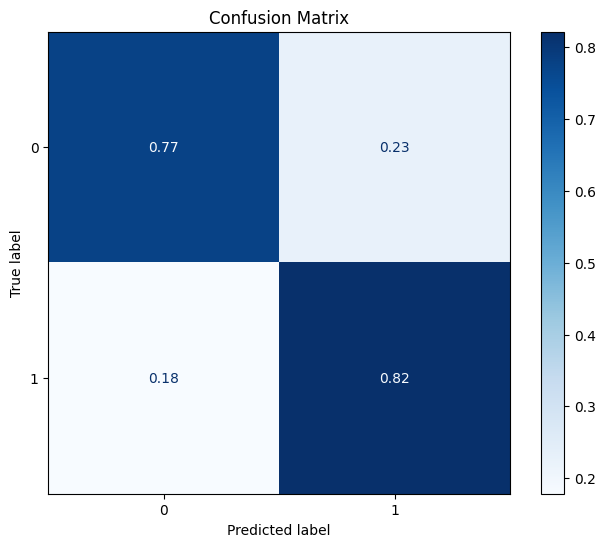

In [25]:
## run the pipeline
print("\n================================================")
print("Score:")
if(X_train_resampled is not None):
    pipe_it(pipeline, X_train_resampled, y_train_resampled, X_test, y_test)
else:
    pipe_it(pipeline, X_train, y_train, X_test, y_test)

print("\n================================================")
inspect_results(pipeline, X_test, y_test)

In [23]:
x_val(pipeline, X_train, y_train)

Cross-validation scores: [0.98527369 0.98541261 0.9850653  0.98527369 0.98492637]
Mean cross-validation score: 0.9851903306474019
